# Adult Income - Classifier Comparison
---
__Date Created:__ 2020-06-16  
__Author:__ Josh Mischung  
__email:__ josh@knoasis.io  

__Dataset:__ [Adult Income, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Adult)

__Comments on Dataset & Objectives:__  
The objective of this notebook is building a classification model that can power a user-facing frontend where inputs are provide by the user and the probability of an outcome is predicted. The Adult dataset from the UCI Machine Learning Repository was chosen for this task because a layperson will intuitively have enough understanding of the inputs to change them and mentally form their own hypothesis about how the change will impact the probability of the outcome (*adult income >$50K*).

<br>

# Imports & Functions
---

__Imports__

In [13]:
# The usual suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# KNN-Imputing
from knn_impute import knn_impute

# More visualization
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from statsmodels.graphics.gofplots import ProbPlot, qqplot

__Functions__

In [67]:
### Data cleaning ###
def distribution_impute(df, col):
    # Record distribution
    attribute_dist = df[col].value_counts(normalize=True)

    # Impute NaN
    nulls = df[col].isna()
    df.loc[nulls, col] = np.random.choice(attribute_dist.index, size=len(df[nulls]),
                                                        p=attribute_dist.values)

    
### Plotting ###
def bar_chart(df, col):
    # Create plotting variables
    plotting_df = df.copy()
    if (plotting_df[col].dtype == int) or (plotting_df[col].dtype == float):
        plotting_df[col].fillna('Null', inplace=True)
    cat_dict = plotting_df[col].value_counts(dropna=False).to_dict()
    x = list(cat_dict.keys())
    y = list(cat_dict.values())
    
    # Create bar chart
    fig = go.Figure(data=[go.Bar(x=x, y=y, text=y, textposition='auto')])
    
    # Label plot
    fig.update_layout(
        title=go.layout.Title(text=f'{col} - Counts by Value'),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
                              text='Categories')),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                              text='Counts')))
    
    # Show bar chart
    fig.show();

    
def grouped_bar_chart(df, feature, target):
    """Produce a plotly based vertical bar chart of feature occurences
    grouped by possible values of target.

    Parameters
    ----------
    df : pandas dataframe
        Typical automotive dataset.

    feature : str, categorical or ordinal  variable
        Column to use for x-axis values of bar chart.

    target : str, categorical or ordinal variable
        Column to use for groupings by feature value.

    Yields
    ------
    plotly grouped bar chart : Bar chart showing occurences of passed in feature grouped
        by passed in target.

    Examples
    --------
    >>> eda.grouped_bar_chart(autos_df, 'cylinders', 'rc_mechanical')
    
    Notes
    -----
    Additional variants of plotly bar charts:
        https://plot.ly/python/bar-charts/
    """

    try:
        assert (type(df) == pd.DataFrame), "ERROR: This function only accepts Pandas DataFrames. Please convert your data to a pd.DataFrame and retry..."
        assert ((type(feature) == str) & (type(target) == str)), "ERROR: Please pass column names as strings..."
        assert (feature in df.columns), "ERROR: The column passed in for feature is not in the passed in dataframe..."
        assert (target in df.columns), "ERROR: The column passed in for target is not in the passed in dataframe..."

    except AssertionError as error:
        print(error)

    else:    
        # Values and counts
        x_vals = df[feature].value_counts().index.tolist()
        y_vals = sorted(df[target].unique().tolist())

        counts_dict = {}
        data = []

        # Create dict of counts by grouping
        for y_val in y_vals:
            counts_dict[y_val] = []
            for x_val in x_vals:
                counts_dict[y_val].append(((df[feature] == x_val) & (df[target] == y_val)).sum())

        # Create list of plotly objects
        for y_val in y_vals:
            data.append(go.Bar(name=y_val, x=x_vals, y=counts_dict[y_val]))

        # Create plot
        fig = go.Figure(data=data)
        fig.update_layout(barmode='group')

        # Label plot
        fig.update_layout(
            title=go.layout.Title(text=f'{feature} Grouped by {target} - Counts by Value'),
            xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
                                text='Categories')),
            yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                                text='Counts')))

        # Show grouped bar chart
        fig.show();
        

def hist_plot(df, col):
    """Produce a pandas-matplotlib based histogram plot with automated calculation
    of number of bins.

    Parameters
    ----------
    df : pandas dataframe
        Typical automotive dataset.

    col : str, continuous variable
        Column to use for histogram.

    Yields
    ------
    matplotlib histogram : Histogram plot showing distribution of passed in feature.

    Examples
    --------
    >>> eda.hist_plot(autos_df, 'perc_profit')
    """

    try:
        assert (type(df) == pd.DataFrame), "ERROR: This function only accepts Pandas DataFrames. Please convert your data to a pd.DataFrame and retry..."
        assert (type(col) == str), "ERROR: Please pass the column name as a string..."
        assert (col in df.columns.tolist()), "ERROR: The column passed is not in the passed dataframe..."

    except AssertionError as error:
        print(error)
    
    else:
        # Create figure
        plt.figure(figsize=(10, 6))
        
        # Create histogram
        df[col].plot(kind='hist')
        
        # Label plot
        plt.title(f"{col} - Histogram")
        plt.xlabel(col)
        plt.show();


def dist_plot(df, col):
    """Produce a seaborn based distribution plot with KDE plot
    imposed on top of histogram plot with automated calculation
    of number of bins.

    Parameters
    ----------
    df : pandas dataframe
        Typical automotive dataset.

    col : str, continuous variable
        Column to use for distribution plot.

    Yields
    ------
    seaborn distribution plot : KDE and histogram plot showing distribution of passed in feature.

    Examples
    --------
    >>> eda.dist_plot(autos_df, 'perc_profit')
    """

    try:
        assert (type(df) == pd.DataFrame), "ERROR: This function only accepts Pandas DataFrames. Please convert your data to a pd.DataFrame and retry..."
        assert (type(col) == str), "ERROR: Please pass the column name as a string..."
        assert (col in df.columns.tolist()), "ERROR: The column passed is not in the passed dataframe..."

    except AssertionError as error:
        print(error)
    
    else:
        # Address Nulls
        null_count = df[col].isna().sum()
        print(f"{null_count} records are null, and not included in the distribution plot.")
        plotting_df = df.loc[df[col].notna(), :]
        
        # Create figure
        plt.figure(figsize=(10, 6))
        
        # Create distribution plot
        sns.distplot(plotting_df[col])
        
        # Label plot
        plt.title(f"{col} - Distribution Plot")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.show();
        
        
def grouped_box_plot(df, feature, target):
    """Produce a pandas-matplotlib based box plot grouped by
    a specificed feature.

    Parameters
    ----------
    df : pandas dataframe
        Typical automotive dataset.

    feature : str, categorical or ordinal variable
        Column by which to group box plots.

    target : str, continuous variable
        Column to use for box plots.

    Yields
    ------
    matplotlib box plots : Box plots showing distribution of passed in target grouped
        by passed in feature.

    Examples
    --------
    >>> eda.grouped_box_plot(autos_df, 'cylinders', 'perc_profit')
    """

    try:
        assert (type(df) == pd.DataFrame), "ERROR: This function only accepts Pandas DataFrames. Please convert your data to a pd.DataFrame and retry..."
        assert ((type(feature) == str) & (type(target) == str)), "ERROR: Please pass column names as strings..."
        assert (feature in df.columns), "ERROR: The column passed in for feature is not in the passed in dataframe..."
        assert (target in df.columns), "ERROR: The column passed in for target is not in the passed in dataframe..."

    except AssertionError as error:
        print(error)

    else:
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create grouped boxplot
        df.loc[:, [feature, target]].boxplot(by=feature, ax=ax)
        
        # Label plot
        ax.set_title(f"Box plot of {target}") # Plot main title
        plt.xticks(rotation=45)
        ax.set_ylabel(target)
        plt.show();

<br>  
# Load & Clean Data
---

In [3]:
# Load data
data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_df = pd.read_csv(data, header=None, na_values=' ?')

# Set column names
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
        'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
        'hours_per_week', 'native_country', 'income']
adult_df.columns = cols

# Convert object dtype to category
adult_df[adult_df.select_dtypes(['object']).columns] = adult_df.select_dtypes(['object']).\
                                                                apply(lambda x: x.astype('category'))

adult_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Metadata
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null category
fnlwgt            32561 non-null int64
education         32561 non-null category
education_num     32561 non-null int64
marital_status    32561 non-null category
occupation        30718 non-null category
relationship      32561 non-null category
race              32561 non-null category
sex               32561 non-null category
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    31978 non-null category
income            32561 non-null category
dtypes: category(9), int64(6)
memory usage: 1.8 MB


<br>  
# Evaluate Nulls
---

In [5]:
# Record location of nulls
missing_indicators = adult_df[['workclass', 'occupation',
                               'native_country']].isna().astype(int)
missing_indicators.columns = ['workclass_null', 'occupation_null', 'native_country_null']
adult_df = pd.concat([adult_df, missing_indicators], axis=1)

In [6]:
# NaN columns
nan_cols = ['workclass', 'occupation', 'native_country']

# Impute Nan
for col in nan_cols:
    distribution_impute(adult_df, col)

<br>  
# EDA
---

__income (Target)__

In [40]:
# Column
col = 'income'

# Bar plot
print("Percent income <=50K:", round((adult_df.loc[adult_df[col] == \
                                    ' <=50K', col].shape[0] / adult_df.shape[0]), 3))
bar_chart(adult_df, col)

Percent income <=50K: 0.759


__Categorical Attributes__

In [52]:
for feat in adult_df.drop('income', 1).select_dtypes('category'):
    bar_chart(adult_df, feat)
    grouped_bar_chart(adult_df, feat, 'income')
    print('\n')
    print('-' * 72)
    print('\n')



------------------------------------------------------------------------






------------------------------------------------------------------------






------------------------------------------------------------------------






------------------------------------------------------------------------






------------------------------------------------------------------------






------------------------------------------------------------------------






------------------------------------------------------------------------






------------------------------------------------------------------------




__Numeric Attributes__

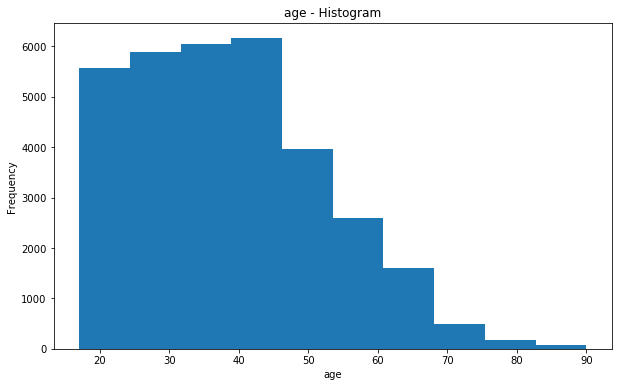

0 records are null, and not included in the distribution plot.


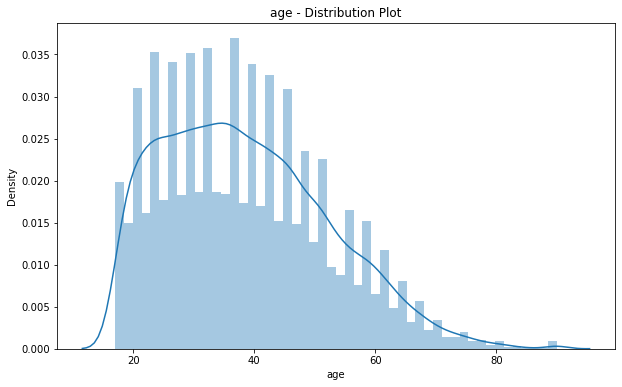

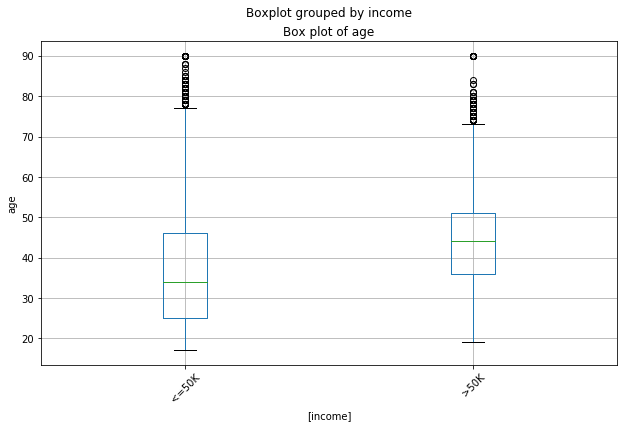



------------------------------------------------------------------------




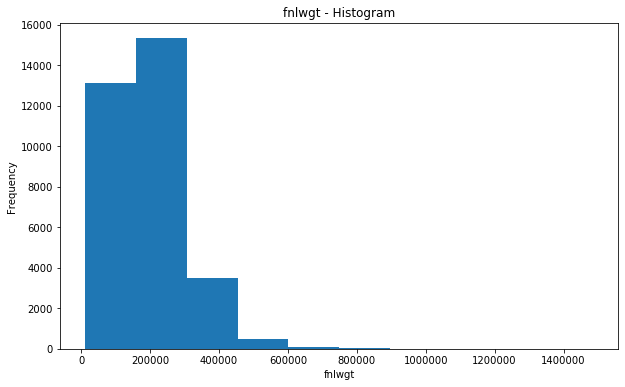

0 records are null, and not included in the distribution plot.


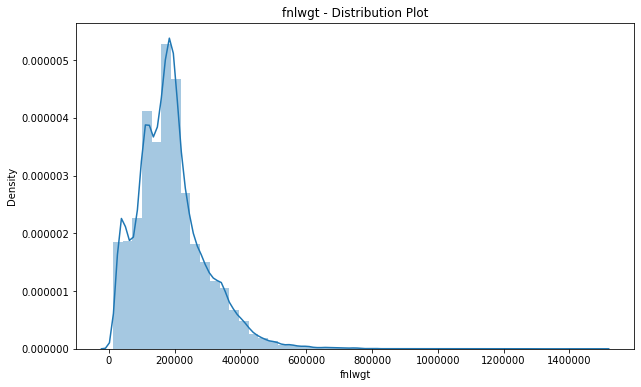

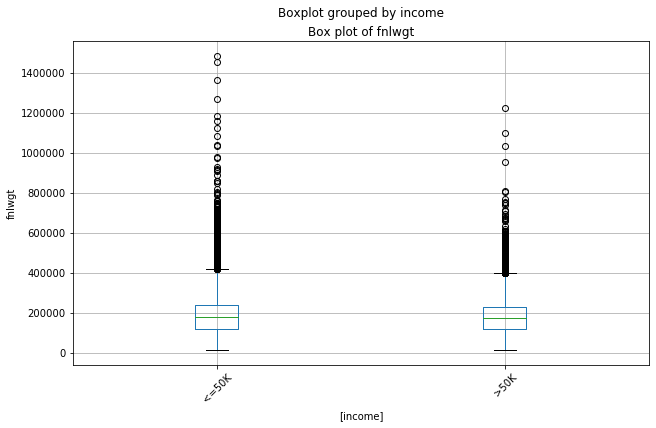



------------------------------------------------------------------------




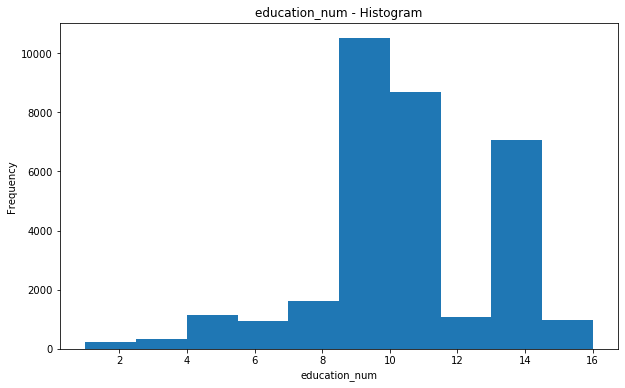

0 records are null, and not included in the distribution plot.


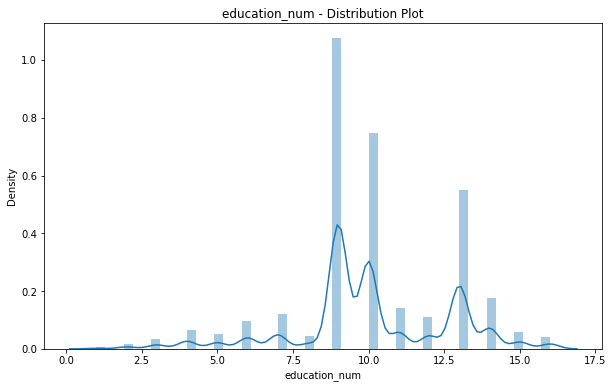

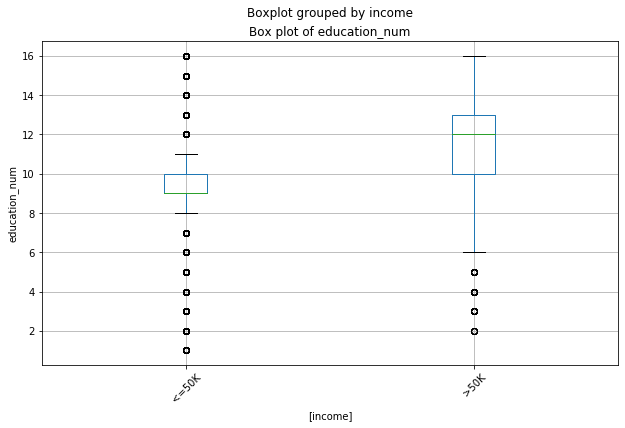



------------------------------------------------------------------------




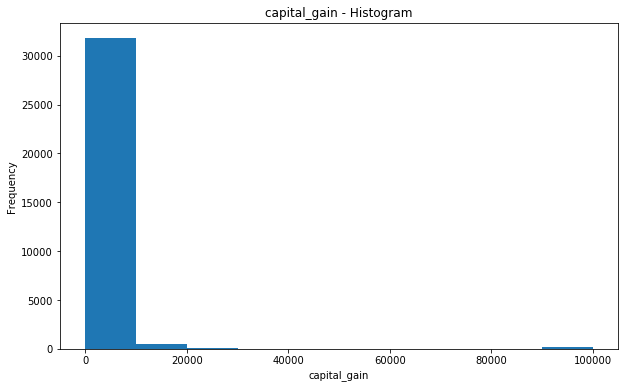

0 records are null, and not included in the distribution plot.


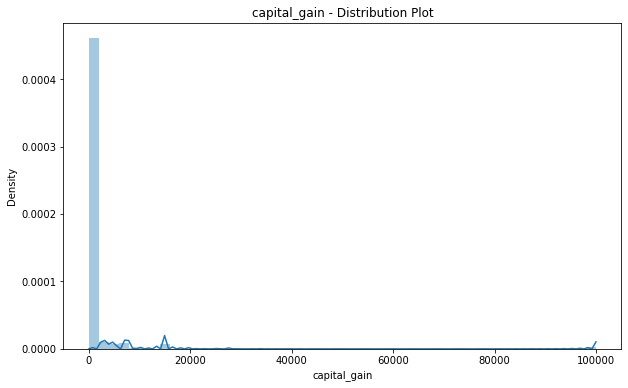

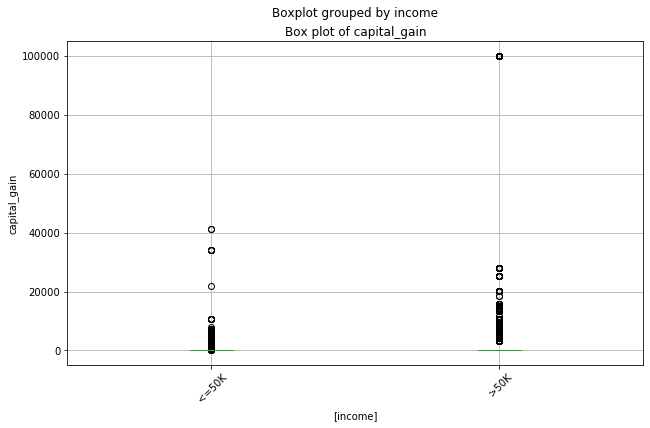



------------------------------------------------------------------------




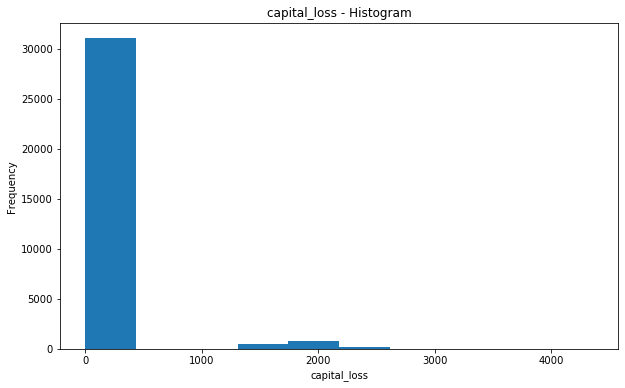

0 records are null, and not included in the distribution plot.


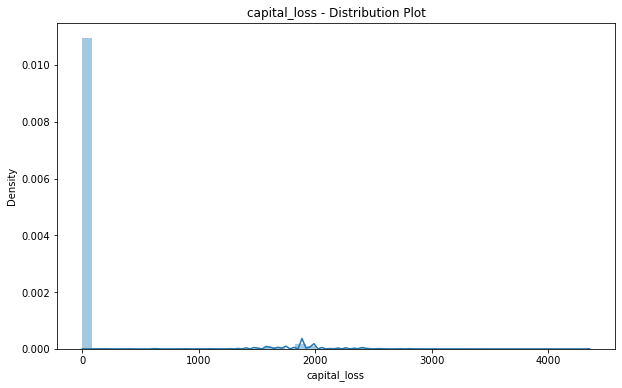

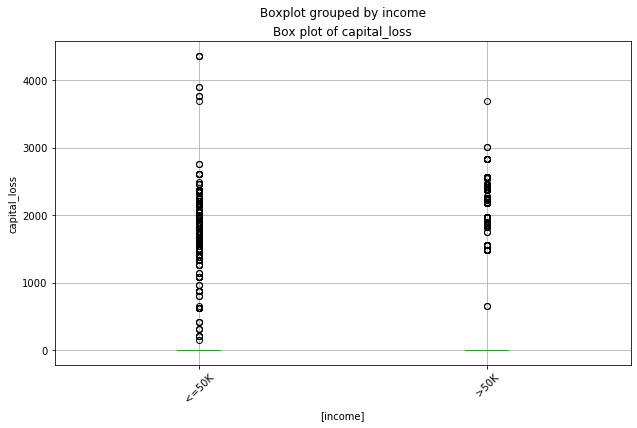



------------------------------------------------------------------------




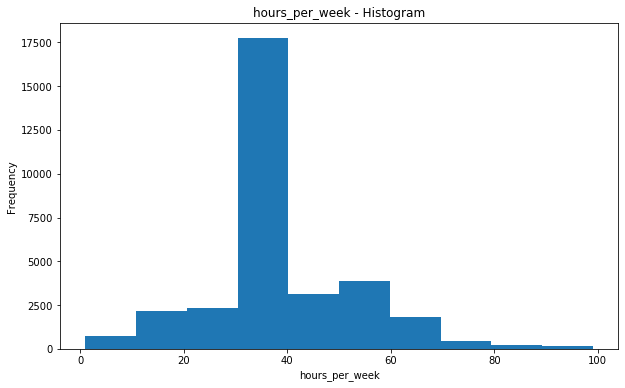

0 records are null, and not included in the distribution plot.


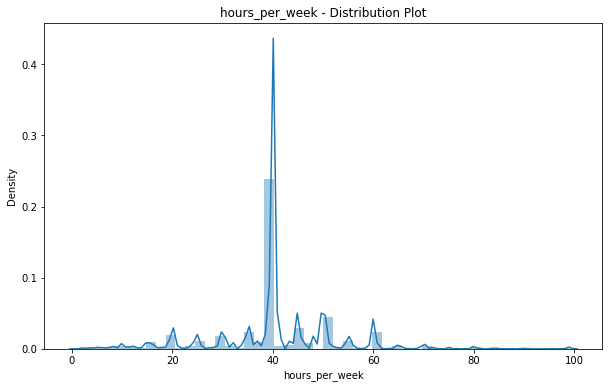

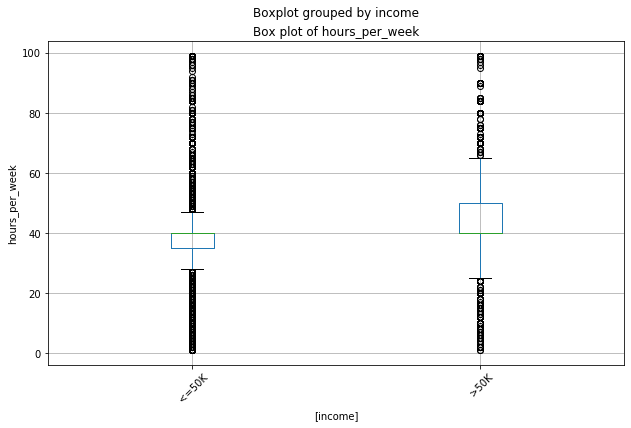



------------------------------------------------------------------------




In [69]:
for feat in adult_df.drop(['workclass_null', 'occupation_null', 'native_country_null'], 1)\
.select_dtypes(['int64']):
    # Histogram
    hist_plot(adult_df, feat)

    # Distribution plot
    dist_plot(adult_df, feat)
    
    # Grouped Boxplot
    grouped_box_plot(adult_df, 'income', feat)
    
    print('\n')
    print('-' * 72)
    print('\n')